In [998]:
import bs4
from bs4 import BeautifulSoup
import requests
import re
import json
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cross_validation import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,\
AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor


In [999]:
# get list of top 250 movies from imdb
URL ="http://www.imdb.com/chart/top"
r = requests.get(URL)
top250_soup = BeautifulSoup(r.content, "lxml")

In [1000]:
# create list of imdb ids and names
name_list = []
id_list = []
for movie in top250_soup.find_all('a', href=re.compile('/title/')):
    name_list.append(movie.text.strip())
    id_list.append(movie["href"])

id_list = [x.split("/")[2] for x in id_list]
id_list = [j for i,j in enumerate(id_list) if i%2]
name_list = [j.encode("utf-8") for i,j in enumerate(name_list) if i%2]

In [1001]:
# use id list to send requests to API
URL_base = "http://www.omdbapi.com/?i={}&plot=full&r=json&tomatoes=true"
# loop over id list to put json output in list
json_list = []
for i in id_list:
    r = requests.get(URL_base.format(i))
    json_list.append(json.loads(r.content))

In [1002]:
json_list[0]

{u'Actors': u'Tim Robbins, Morgan Freeman, Bob Gunton, William Sadler',
 u'Awards': u'Nominated for 7 Oscars. Another 15 wins & 21 nominations.',
 u'BoxOffice': u'N/A',
 u'Country': u'USA',
 u'DVD': u'27 Jan 1998',
 u'Director': u'Frank Darabont',
 u'Genre': u'Crime, Drama',
 u'Language': u'English',
 u'Metascore': u'80',
 u'Plot': u"Chronicles the experiences of a formerly successful banker as a prisoner in the gloomy jailhouse of Shawshank after being found guilty of a crime he did not commit. The film portrays the man's unique way of dealing with his new, torturous life; along the way he befriends a number of fellow prisoners, most notably a wise long-term inmate named Red.",
 u'Poster': u'http://ia.media-imdb.com/images/M/MV5BODU4MjU4NjIwNl5BMl5BanBnXkFtZTgwMDU2MjEyMDE@._V1_SX300.jpg',
 u'Production': u'Columbia Pictures',
 u'Rated': u'R',
 u'Released': u'14 Oct 1994',
 u'Response': u'True',
 u'Runtime': u'142 min',
 u'Title': u'The Shawshank Redemption',
 u'Type': u'movie',
 u'Web

In [1003]:
# create list of features to extract from json
cols = ["imdbRating", "Title","Rated","Country", "Genre", "Year","Awards","Runtime","Director",\
       "Actors","Plot","Metascore","imdbVotes", "Language","tomatoMeter","tomatoRotten","tomatoFresh"]

In [1004]:
# create dictionary of results for movies; key is id, value is dictionary of fields
movie_dict={}
for i, j in zip(id_list,json_list):
    temp_dict = {}
    for col in cols:
        temp_dict[col]=j[col]
    movie_dict[i] = temp_dict 

In [1005]:
# create df of data from API
movie_df = pd.DataFrame([k for k,v in movie_dict.iteritems()], columns=["id"])
for col in cols:
    movie_df = pd.merge(movie_df,pd.DataFrame([(k,v[col]) for k,v in movie_dict.iteritems()], columns=["id","var"]),\
                        on ="id", how="left")

In [1006]:
# rename columns
col_names = ["id"]
col_names.extend(cols)
movie_df.columns = col_names

In [1007]:
# visit imdb page for each movie (by imdb id) and collect content
URL_base = "http://www.imdb.com/title/{}"
imdb_list = []
for i in id_list:
    r = requests.get(URL_base.format(i))
    imdb_soup = BeautifulSoup(r.content, "lxml")
    imdb_list.append(imdb_soup)

In [1008]:
# functions to extract gross and budget from pages
def extract_gross(page):
    for i in page.find_all("h4", class_="inline"):
        if i.text == "Gross:":
            return i.next_sibling.strip()
def extract_budget(page):
    for i in page.find_all("h4", class_="inline"):
        if i.text == "Budget:":
            return i.next_sibling.strip()

In [1009]:
# scrape budget and gross from pages, create a df
gross_list = []
budget_list = []
for page in imdb_list:
    gross_list.append(extract_gross(page))
    budget_list.append(extract_budget(page))

imdb_df = pd.DataFrame(id_list, columns = ["id"])
imdb_df["Budget"] = budget_list
imdb_df["Gross"] = gross_list

In [1010]:
# merge the two dfs on id
df = pd.merge(movie_df, imdb_df, on="id", how="left")
df.head(1)

,id,imdbRating,Title,Rated,Country,Genre,Year,Awards,Runtime,Director,Actors,Plot,Metascore,imdbVotes,Language,tomatoMeter,tomatoRotten,tomatoFresh,Budget,Gross
0,tt2582802,8.5,Whiplash,R,USA,"Drama, Music",2014,Won 3 Oscars. Another 87 wins & 128 nominations.,107 min,Damien Chazelle,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",A young and talented drummer attending a prest...,88,"384,504",English,94,15,243,"$3,300,000","$13,092,000"


### Basic data cleaning

In [1011]:
# replace N/A with np.nan
df.replace("N/A", np.nan, inplace=True)

In [1012]:
# check variable types
df.dtypes

id              object
imdbRating      object
Title           object
Rated           object
Country         object
Genre           object
Year            object
Awards          object
Runtime         object
Director        object
Actors          object
Plot            object
Metascore       object
imdbVotes       object
Language        object
tomatoMeter     object
tomatoRotten    object
tomatoFresh     object
Budget          object
Gross           object
dtype: object

In [1013]:
# convert strings to numbers as appropriate
df["imdbRating"]=pd.to_numeric(df["imdbRating"], errors='ignore')
df["Year"]=pd.to_numeric(df["Year"], errors='ignore')
df["Metascore"]=pd.to_numeric(df["Metascore"], errors='ignore')
df["imdbVotes"] = df["imdbVotes"].apply(lambda x: x.replace(",",""))
df["imdbVotes"]=pd.to_numeric(df["imdbVotes"], errors='ignore')
df["tomatoMeter"]=pd.to_numeric(df["tomatoMeter"], errors='ignore')
df["tomatoFresh"]=pd.to_numeric(df["tomatoFresh"], errors='ignore')
df["tomatoRotten"]=pd.to_numeric(df["tomatoRotten"], errors='ignore')

In [1014]:
# convert runtime to number of mins
def mins_to_int(x):
    return int(x.replace(" min",""))
df["Runtime"] = df["Runtime"].apply(mins_to_int)

In [1015]:
# create count of number of top 10 Actors in each film

cvec=CountVectorizer()

# create column of firstname concatenated with last name to identify unique people
df["Actor Names"] = df["Actors"].apply(lambda x: x.lower().replace(" ",""))
cvec.fit(df["Actor Names"])
actors  = pd.DataFrame(cvec.transform(df["Actor Names"]).todense(),
             columns=cvec.get_feature_names())

# list of top 10 actors
top_actors =actors.sum(axis=0).sort_values(ascending=False)[:10]
cvec.fit(top_actors.index)
actors_count  = pd.DataFrame(cvec.transform(df["Actor Names"]).todense(),
             columns=cvec.get_feature_names())

# count of number of top 10 actors in each film
df["Actor Count"] = actors_count.sum(axis=1)

In [1016]:
# repeat for directors
df["Director Names"] = df["Director"].apply(lambda x: x.lower().replace(" ",""))
cvec.fit(df["Director Names"])
directors  = pd.DataFrame(cvec.transform(df["Director Names"]).todense(),
             columns=cvec.get_feature_names())
top_directors =directors.sum(axis=0).sort_values(ascending=False)[:10]
cvec.fit(top_directors.index)
directors_count  = pd.DataFrame(cvec.transform(df["Director Names"]).todense(),
             columns=cvec.get_feature_names())
df["Director Count"] = directors_count.sum(axis=1)

In [1017]:
# repeat for plot words
cvec = CountVectorizer(stop_words='english')
cvec.fit(df["Plot"])
plots  = pd.DataFrame(cvec.transform(df["Plot"]).todense(),
             columns=cvec.get_feature_names())
top_plots = plots.sum(axis=0).sort_values(ascending=False)[:10]
cvec.fit(top_plots.index)
plots_count  = pd.DataFrame(cvec.transform(df["Plot"]).todense(),
             columns=cvec.get_feature_names())
df["Plot Count"] = plots_count.sum(axis=1)

In [1018]:
# repeat for title words
cvec.fit(df["Title"])
titles  = pd.DataFrame(cvec.transform(df["Title"]).todense(),
             columns=cvec.get_feature_names())
top_titles = titles.sum(axis=0).sort_values(ascending=False)[:10]
cvec.fit(top_titles.index)
titles_count  = pd.DataFrame(cvec.transform(df["Title"]).todense(),
             columns=cvec.get_feature_names())
df["Title Count"] = titles_count.sum(axis=1)

In [1019]:
# drop original columns from df
drop_cols = ["Actors", "Director", "Plot", "Title", "Actor Names", "Director Names"]
df.drop(drop_cols, axis=1, inplace=True)


In [1020]:
# create column for number of oscars won
def oscars(x):
    try:
        oscar = re.findall(r"([^.]*?Oscar[^.]*\.)",x)[0].split()
        if oscar[0]=="Won":
            return oscar[1]
        else:
            return 0
    except:
        return 0
df["Oscar"] = df["Awards"].apply(oscars)


In [1021]:
# drop awards columns
df.drop("Awards", axis=1, inplace=True)

In [1022]:
#create dummy cols for genre
df = df.join(df["Genre"].str.get_dummies(sep=','))

In [1023]:
df.drop(df.columns[20:40], axis=1, inplace=True)

In [1024]:
# drop original genre column
df.drop("Genre", axis=1, inplace=True)

In [1025]:
# create a dummy for whether the film is affiliated with the US
df["US"] = df["Country"].apply(lambda x: "USA" in x).astype(int)

In [1026]:
# drop country column
df.drop("Country", axis=1, inplace=True)

### Missing Data

In [1027]:
# check for missingness
np.sum(df.isnull()).sort_values(ascending=False)

Metascore         82
Gross             65
Budget            18
tomatoMeter        5
tomatoRotten       5
tomatoFresh        5
Rated              1
Language           1
US                 0
Western            0
imdbRating         0
Year               0
Runtime            0
imdbVotes          0
Actor Count        0
Director Count     0
Plot Count         0
Title Count        0
Oscar              0
Action             0
Adventure          0
Animation          0
Biography          0
Comedy             0
Crime              0
Drama              0
Film-Noir          0
Horror             0
Mystery            0
Sci-Fi             0
Thriller           0
id                 0
dtype: int64

In [1028]:
# look at film with missing language 
df[pd.isnull(df["Language"])]

,id,imdbRating,Rated,Year,Runtime,Metascore,imdbVotes,Language,tomatoMeter,tomatoRotten,...,Comedy,Crime,Drama,Film-Noir,Horror,Mystery,Sci-Fi,Thriller,Western,US
194,tt0018455,8.3,NOT RATED,1927,94,NaN,28871,NaN,98.0,1.0,...,0,0,1,0,0,0,0,0,0,1


In [1029]:
# film was silent American film
df["Language"] = df["Language"].apply(lambda x: "Silent" if pd.isnull(x) else x)

In [1030]:
# create binary for whether the film is at least partially in english
df["English"] = df["Language"].apply(lambda x: "English" in x).astype(int)

In [1031]:
# drop Language
df.drop("Language", axis=1, inplace=True)

In [1032]:
# value counts for rated
df["Rated"].value_counts(dropna=False)

R            104
PG            37
NOT RATED     35
PG-13         34
G             13
APPROVED      11
UNRATED       10
PASSED         3
X              1
M              1
NaN            1
Name: Rated, dtype: int64

In [1033]:
# set not rated to unrated, approved to passed, M to G, NaN to not rated
def update_rating(x):
    if x=="NOT RATED":
        return "UNRATED"
    elif x=="APPROVED":
        return "PASSED"
    elif x=="M":
        return "G"
    elif pd.isnull(x):
        return "UNRATED"
    else:
        return x
df["Rated"] = df["Rated"].apply(update_rating)

# reassign Rated to dummies
df = df.join(pd.get_dummies(df['Rated'], prefix='Rated'))

In [1034]:
# drop Rated column
df.drop("Rated", axis=1, inplace=True)

In [1035]:
# drop X rated to make it the base reference for rating
df.drop("Rated_X", axis=1, inplace=True)

In [1036]:
np.sum(df.isnull())

id                 0
imdbRating         0
Year               0
Runtime            0
Metascore         82
imdbVotes          0
tomatoMeter        5
tomatoRotten       5
tomatoFresh        5
Budget            18
Gross             65
Actor Count        0
Director Count     0
Plot Count         0
Title Count        0
Oscar              0
Action             0
Adventure          0
Animation          0
Biography          0
Comedy             0
Crime              0
Drama              0
Film-Noir          0
Horror             0
Mystery            0
Sci-Fi             0
Thriller           0
Western            0
US                 0
English            0
Rated_G            0
Rated_PASSED       0
Rated_PG           0
Rated_PG-13        0
Rated_R            0
Rated_UNRATED      0
dtype: int64

In [1037]:
# try to impute missing tomato scores through linear regression
# make list of features with missingness (exclude these as predictors of tomato scores)
missing_vals = list(df.columns[np.sum(df.isnull())>0].values)

In [1038]:
missing_vals

['Metascore', 'tomatoMeter', 'tomatoRotten', 'tomatoFresh', 'Budget', 'Gross']

In [1039]:
# list of cols of data with no missingness
sub_cols = [i for i in df.columns.values if i not in missing_vals]

In [1040]:
# remove id and rating from columns
sub_cols = sub_cols[2:]
# add back tomato scores
sub_cols.extend(["tomatoMeter", "tomatoFresh","tomatoRotten"])

In [1041]:
# create df of predictors to impute tomato scores with only complete cases
no_miss= df.loc[:,sub_cols]
no_miss = no_miss.dropna()

In [1042]:
# use linear regression to predict tomotoMeter
x = no_miss.drop(["tomatoMeter","tomatoRotten","tomatoFresh"], axis=1)

def test_tomato_pred(name):
    y = no_miss[name]
    lin = LinearRegression()
    lin.fit(x,y)
    y_pred = lin.predict(x)
    print name, r2_score(y,y_pred)
    return lin

#test how well the model predicts (r2 score)
print test_tomato_pred("tomatoMeter")
print test_tomato_pred("tomatoFresh")
print test_tomato_pred("tomatoRotten")

tomatoMeter 0.341538005792
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
tomatoFresh 0.603367008905
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
tomatoRotten 0.498311808641
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [1043]:
# regressions looks ok to predict 5 missing values
pred_cols = [i for i in sub_cols if i not in ["imdbRating","tomatoMeter","tomatoFresh","tomatoRotten"]]

def impute_tomato(row,name):
    if pd.isnull(row[name]):
        x = row[pred_cols]
        return lin.predict(x.reshape(1,-1))[0]
    else:
        return row[name]
    
lin = test_tomato_pred("tomatoMeter")
df["tomatoMeter"] = df.apply(lambda x: impute_tomato(x,"tomatoMeter"), axis=1)
lin = test_tomato_pred("tomatoFresh")
df["tomatoFresh"] = df.apply(lambda x: impute_tomato(x,"tomatoFresh"), axis=1)
lin = test_tomato_pred("tomatoRotten")
df["tomatoRotten"] = df.apply(lambda x: impute_tomato(x,"tomatoRotten"), axis=1)

tomatoMeter 0.341538005792
tomatoFresh 0.603367008905
tomatoRotten 0.498311808641


In [1044]:
# clean up budget to make anything with a $ an iteger.  mark remainder as missing (this includes foreign films)
def clean_budget(x):
    try:
        return int(x.replace("$","").replace(",",""))
    except:
        return np.nan
df["Budget_clean"] = df["Budget"].apply(clean_budget)

In [1047]:
# load inflation index data to normalize the budgets
cpi = pd.read_csv("cpi.csv", header=None)

In [1048]:
cpi.columns = ["Year","CPI"]

In [1049]:
# normalize at 2000 dollars
base_cpi = cpi[cpi["Year"]==2000]["CPI"]
cpi["cpi_2000"] = cpi["CPI"].apply(lambda x: base_cpi/x)

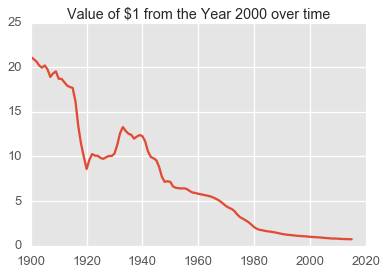

In [1050]:
# clean this up
plt.plot(cpi["Year"],cpi["cpi_2000"])
plt.title("Value of $1 from the Year 2000 over time")

In [1051]:
# create sub df of just year and budget
budget_df = df.loc[:,["Year","Budget_clean"]]

In [1052]:
# merge with CPI
budget_df = pd.merge(budget_df,cpi,how="left",on="Year")

In [1053]:
# calculate budget in Y2000 dollars
budget_df["Budget_real"] = budget_df["Budget_clean"] * budget_df["cpi_2000"]

In [1054]:
# merge real budget onto df
df["Budget_real"] = budget_df["Budget_real"]

In [1055]:
# clean up gross 
df["Gross_clean"] = df["Gross"].apply(clean_budget)

In [1056]:
# convert gross to Y2000 dollars
gross_df = df.loc[:,["Year","Gross_clean"]]
gross_df = pd.merge(gross_df,cpi,how="left",on="Year")
gross_df["Gross_real"] = gross_df["Gross_clean"] * gross_df["cpi_2000"]
df["Gross_real"] = gross_df["Gross_real"]

In [1057]:
# drop original budget and gross
df.drop(["Gross", "Gross_clean","Budget", "Budget_clean"], axis=1, inplace=True)


In [1060]:
# check again for missingness
np.sum(df.isnull()).sort_values(ascending = False).head()
# still on Metascore, gross, budget

Metascore      82
Gross_real     68
Budget_real    36
Year            0
Runtime         0
dtype: int64

In [1061]:
# check correlation between missing variables and rating
df.corr().loc[["Metascore","Gross_real","Budget_real"],"imdbRating"]

Metascore      0.123699
Gross_real     0.088774
Budget_real    0.086901
Name: imdbRating, dtype: float64

In [1062]:
# they seem correlated so imputation probably prudent
# tomatoMeter and Metascore are both measures of critics' reviews.  Check correlation between the two.
df.loc[:,["Metascore","tomatoMeter"]].corr()

,Metascore,tomatoMeter
Metascore,1.000000,0.721438
tomatoMeter,0.721438,1.000000


In [1063]:
# tomatoMeter and Metascore pretty highly correlated.  Metascore is missing ~30% of values, so will drop as a predictor
# since they are both similar measures
df.drop("Metascore", axis=1, inplace=True)

In [1064]:
# imputation of budget and gross: check whether other features are correlated
df.corr().loc[:,["Budget_real","Gross_real"]]

,Budget_real,Gross_real
imdbRating,0.086901,0.088774
Year,0.406102,-0.150938
Runtime,0.282664,0.242962
imdbVotes,0.542275,0.224034
tomatoMeter,-0.186301,0.064306
tomatoRotten,0.413021,-0.032996
tomatoFresh,0.620777,0.080574
Actor Count,0.328244,0.215655
Director Count,0.029699,-0.026766
Plot Count,-0.060242,0.062198


In [1065]:
# try to impute missing values for budget using linear regression
sub_cols = list(df.columns.values)[2:]

In [1066]:
# create df of predictors to impute tomato scores with only complete cases
no_miss= df.loc[:,sub_cols]
no_miss = no_miss.dropna()

In [1067]:
# use linear regression to predict Budget real
x = no_miss.drop(["Budget_real","Gross_real"], axis=1)

def test_tomato_pred(name):
    y = no_miss[name]
    lin = LinearRegression()
    lin.fit(x,y)
    y_pred = lin.predict(x)
    print name, r2_score(y,y_pred)
    return lin

print test_tomato_pred("Budget_real")
print test_tomato_pred("Gross_real")


Budget_real 0.734220878025
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Gross_real 0.50637929127
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [1068]:
# looks good, let's impute
pred_cols = [i for i in sub_cols if i not in ["Gross_real","Budget_real"]]

def impute_tomato(row,name):
    if pd.isnull(row[name]):
        x = row[pred_cols]
        return lin.predict(x.reshape(1,-1))[0]
    else:
        return row[name]
    
lin = test_tomato_pred("Gross_real")
df["Gross_real_i"] = df.apply(lambda x: impute_tomato(x,"Gross_real"), axis=1)
lin = test_tomato_pred("Budget_real")
df["Budget_real_i"] = df.apply(lambda x: impute_tomato(x,"Budget_real"), axis=1)

Gross_real 0.50637929127
Budget_real 0.734220878025


In [1070]:
# check min value for budget
sum(df["Budget_real_i"]<0)

15

In [1071]:
# imputation with linear regression leads to a lot of negative values, so is probably not appropriate
# use means instead

df["Gross_real_i"] = imp.fit_transform(df["Gross_real"]).T
df["Budget_real_i"] = imp.fit_transform(df["Budget_real"]).T

/Users/pt/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/pt/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(array([ 104.,   47.,   16.,   17.,    9.,    6.,    7.,    4.,    2.,    2.]),
 array([  1.93121495e+05,   1.89246260e+07,   3.76561305e+07,
          5.63876351e+07,   7.51191396e+07,   9.38506441e+07,
          1.12582149e+08,   1.31313653e+08,   1.50045158e+08,
          1.68776662e+08,   1.87508167e+08]),
 <a list of 10 Patch objects>)

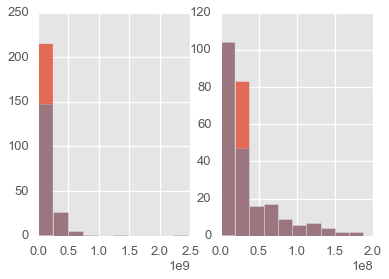

In [1072]:
#check the relative distributions
budget = df[~pd.isnull(df["Budget_real"])]["Budget_real"]
gross = df[~pd.isnull(df["Gross_real"])]["Gross_real"]

fig, ax = plt.subplots(1,2)
ax[0].hist(df["Gross_real_i"], alpha = 0.8)
ax[0].hist(gross, alpha =0.4)
ax[1].hist(df["Budget_real_i"], alpha =0.8)
ax[1].hist(budget, alpha =0.4)

In [1073]:
# looks ok, so drop original variables
df.drop(["Budget_real","Gross_real"], axis=1, inplace=True)

In [1074]:
# check that there is no more missingness
np.sum(df.isnull())

id                0
imdbRating        0
Year              0
Runtime           0
imdbVotes         0
tomatoMeter       0
tomatoRotten      0
tomatoFresh       0
Actor Count       0
Director Count    0
Plot Count        0
Title Count       0
Oscar             0
Action            0
Adventure         0
Animation         0
Biography         0
Comedy            0
Crime             0
Drama             0
Film-Noir         0
Horror            0
Mystery           0
Sci-Fi            0
Thriller          0
Western           0
US                0
English           0
Rated_G           0
Rated_PASSED      0
Rated_PG          0
Rated_PG-13       0
Rated_R           0
Rated_UNRATED     0
Gross_real_i      0
Budget_real_i     0
dtype: int64

### EDA

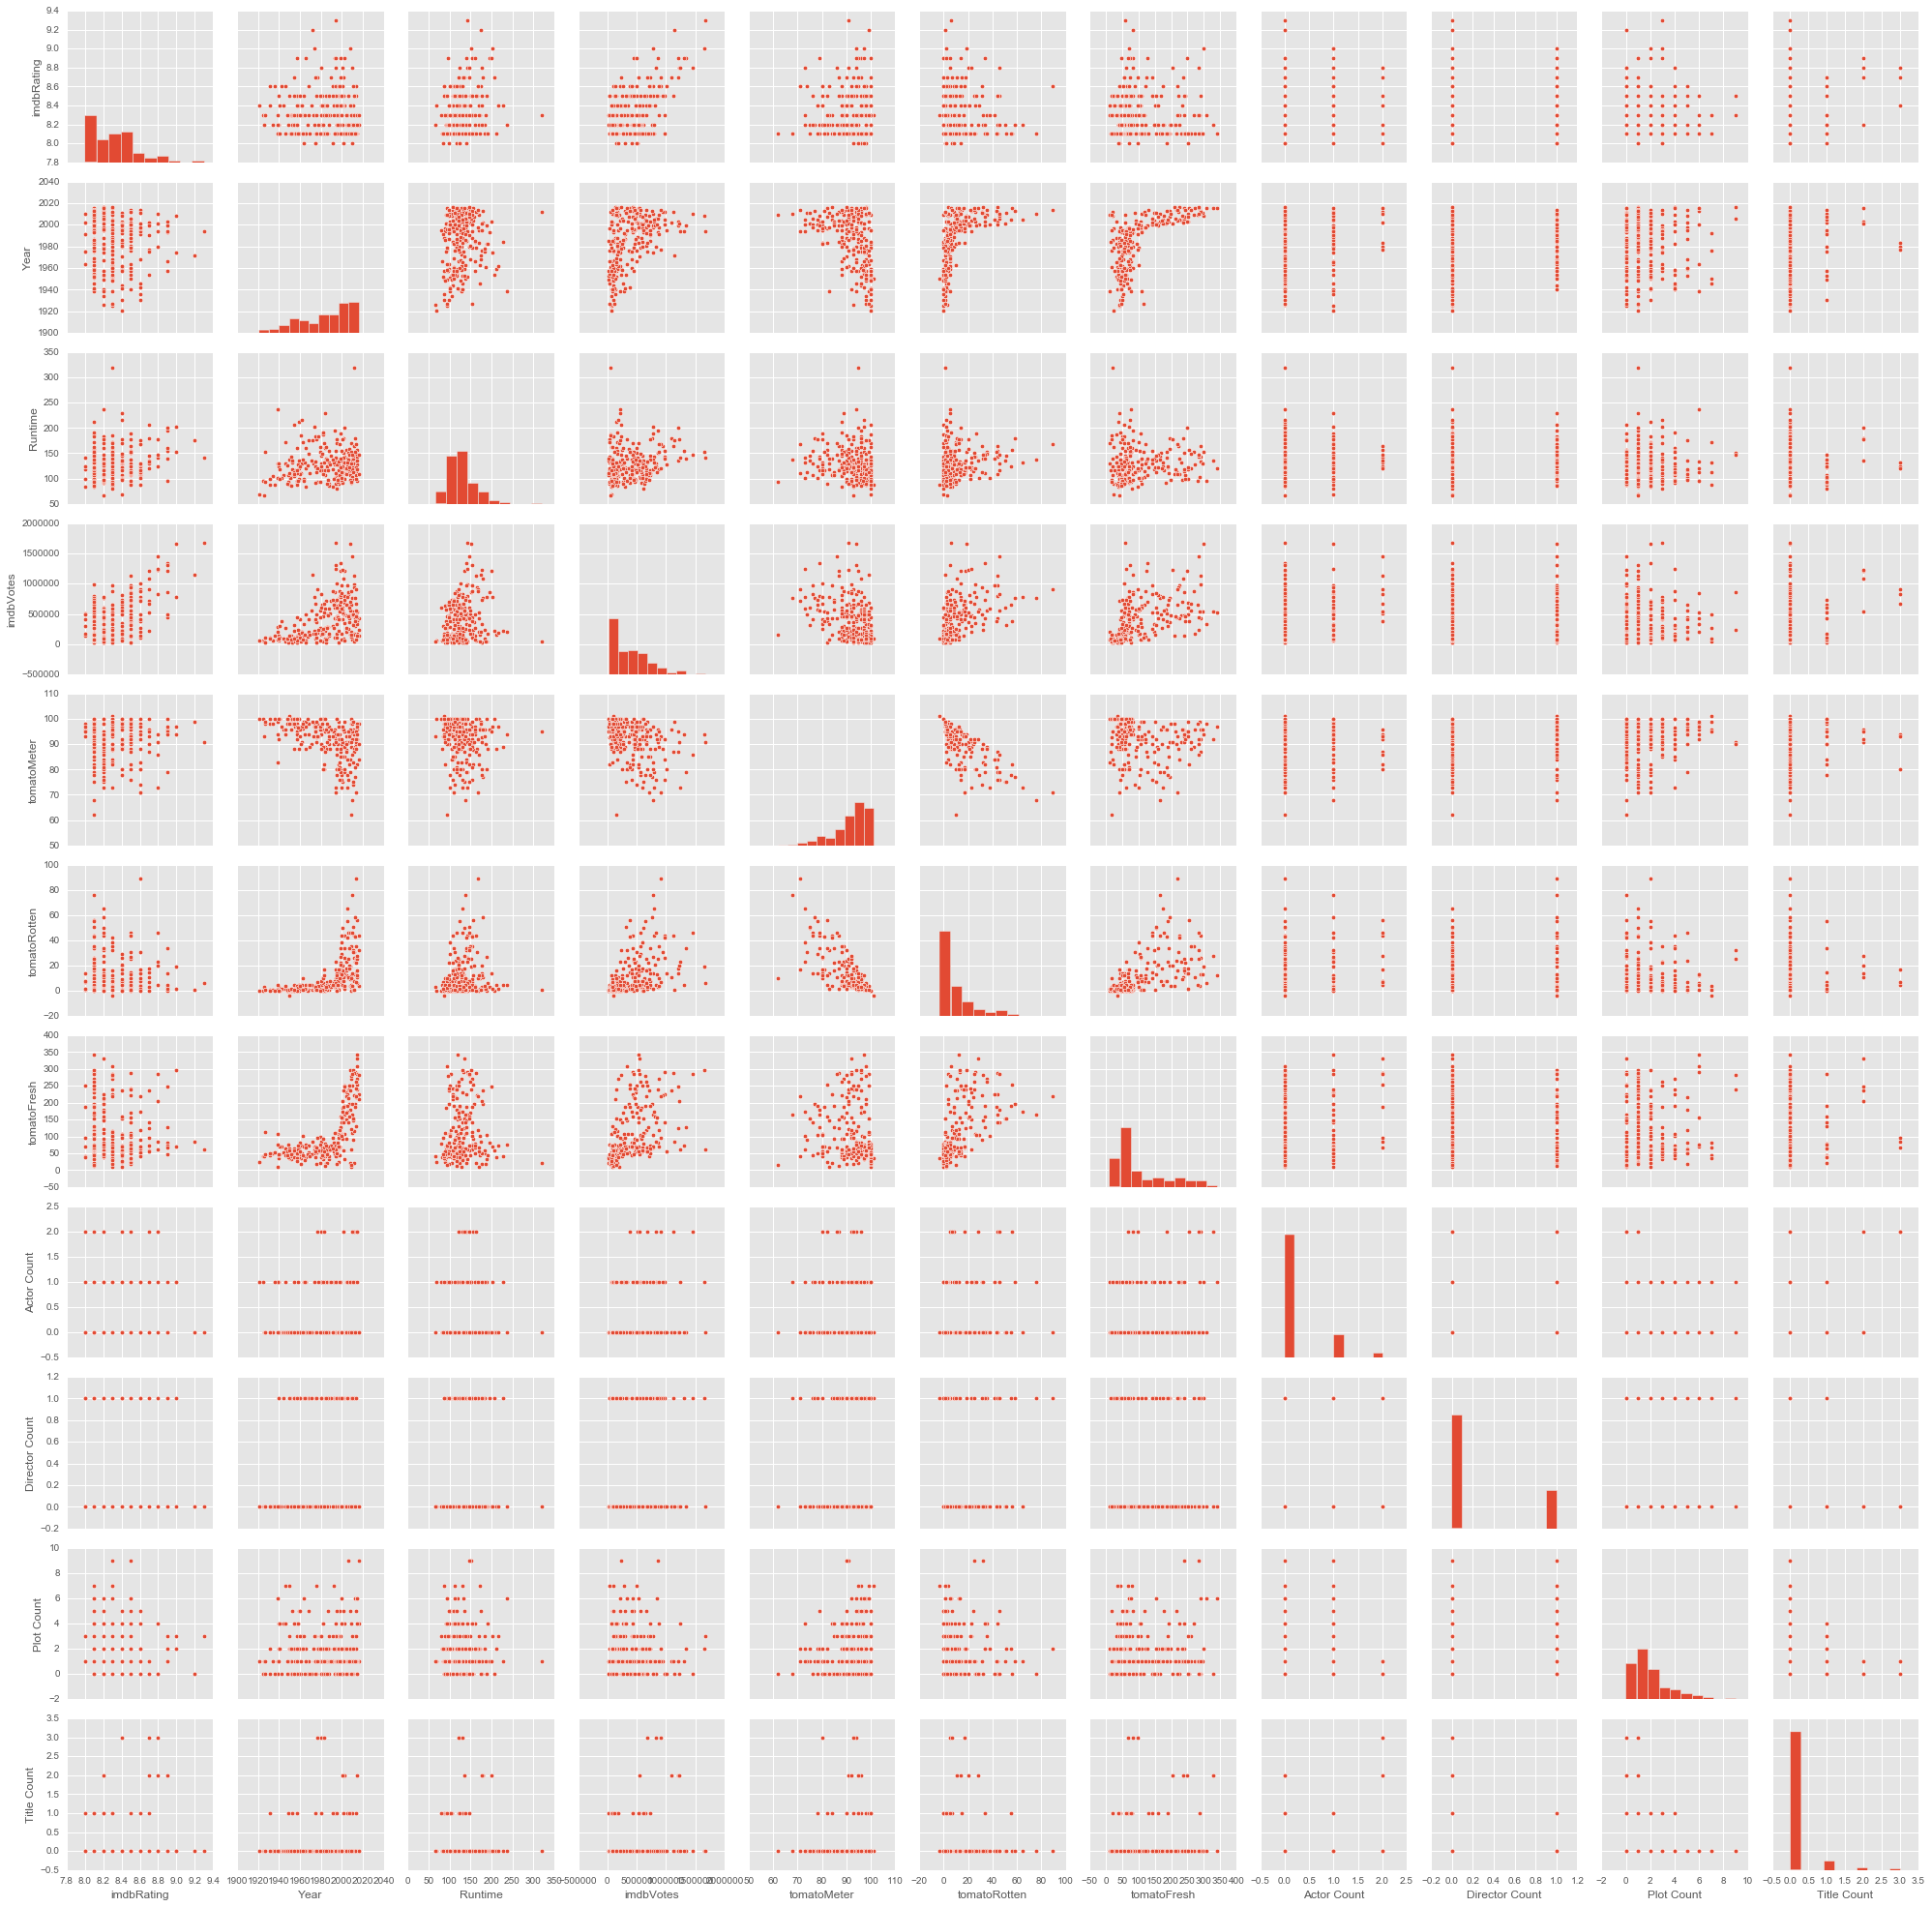

In [634]:
numeric_cols = df.columns.values[1:12]
num = df.loc[:,numeric_cols]
sns.pairplot(num)

(array([ 7.8,  8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4]),
 <a list of 9 Text yticklabel objects>)

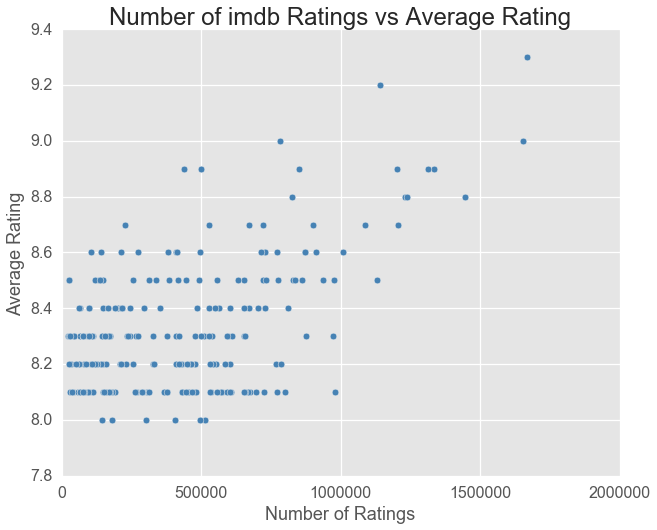

In [1114]:
# number of ratings vs rating, coloured by tomatoMeter
plt.figure(figsize = (10,8))
plt.scatter(df["imdbVotes"],df["imdbRating"],s=45, c="SteelBlue")
plt.xlim(0,2000000)
plt.title("Number of imdb Ratings vs Average Rating", fontsize = 24)
plt.xlabel("Number of Ratings", fontsize = 18)
plt.ylabel("Average Rating", fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([ 7.8,  8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4]),
 <a list of 9 Text yticklabel objects>)

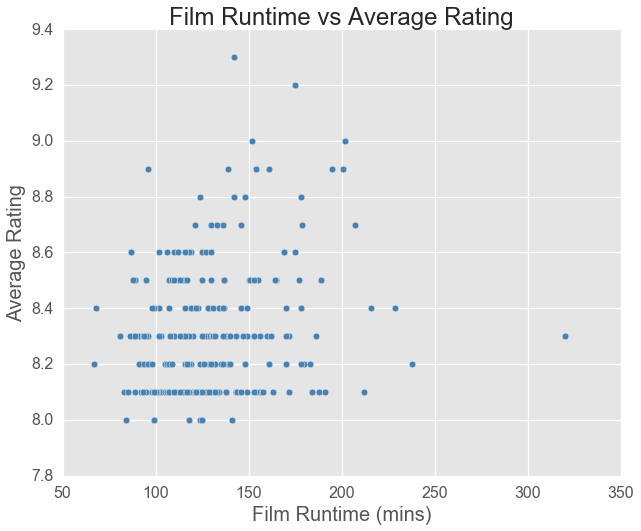

In [1076]:
# Runtime vs rating
plt.figure(figsize = (10,8))
plt.scatter(df["Runtime"],df["imdbRating"],s=45, c="SteelBlue")
plt.title("Film Runtime vs Average Rating", fontsize = 24)
plt.xlabel("Film Runtime (mins)", fontsize = 20)
plt.ylabel("Average Rating", fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([ 7.8,  8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4]),
 <a list of 9 Text yticklabel objects>)

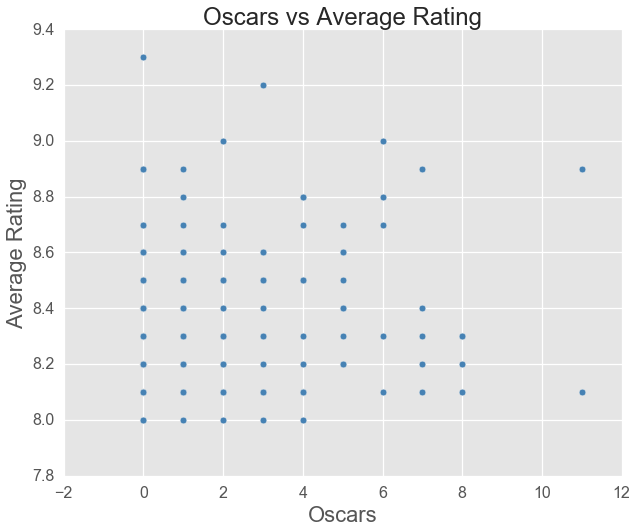

In [1116]:
# Year vs rating
plt.figure(figsize = (10,8))
plt.scatter(df["Oscar"],df["imdbRating"],s=45, c="SteelBlue")
plt.title("Oscars vs Average Rating", fontsize = 24)
plt.xlabel("Oscars", fontsize = 22)
plt.ylabel("Average Rating", fontsize = 22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

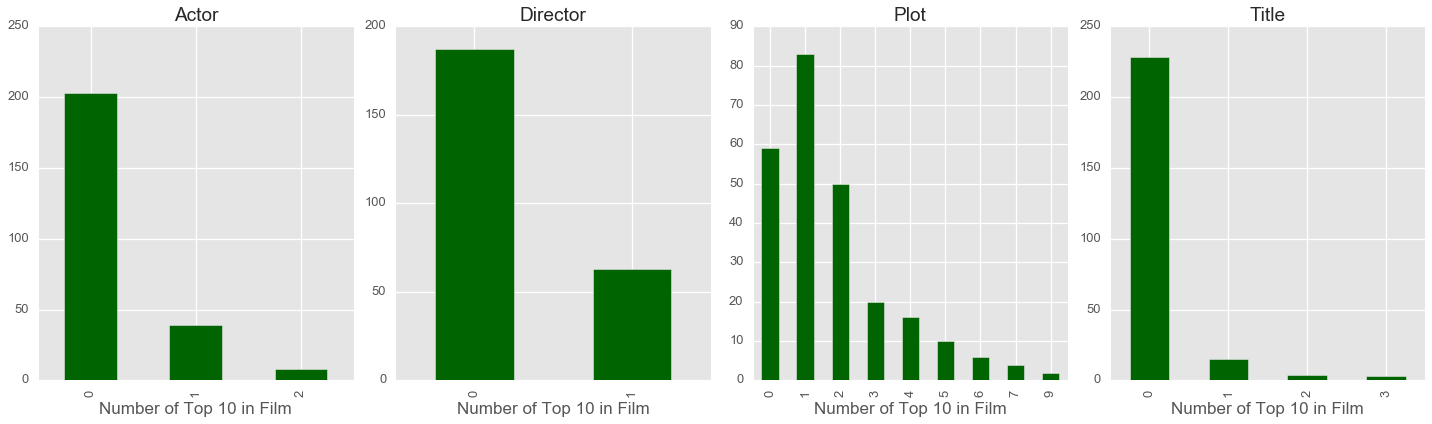

In [1078]:
# bar charts of counts of top tens
fig, ax = plt.subplots(1,4, figsize=(20,6))
bar_list=["Actor Count","Director Count","Plot Count", "Title Count"]

for ax, var in zip(ax, bar_list):
    df[var].value_counts().sort_index().plot(kind="bar", ax=ax, color="darkgreen")
    ax.set_title(var.split()[0], fontsize=19)
    ax.set_xlabel("Number of Top 10 in Film", fontsize=17)  
plt.tight_layout()

** Although number of votes seems like a strong predictor of average votes, it will be excluded from predictive models since in a case where a movie is not yet on the platform, and rating is being predicted, number of ratings would also not be known.**

### Regression

In [1079]:
# set x and y, need to also drop number of imdb ratings
y = df["imdbRating"]
x = df.drop(["id","imdbRating", "imdbVotes"], axis=1)

In [1080]:
# initialize the cv
cv = KFold(len(df),3,shuffle=True, random_state=3)

In [1081]:
# initialize the train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=0.30,
                                                        random_state=14)

In [1084]:
# functions to print out results of model fits
def grid_search_results(model, x, y, cv):
    
    m = np.mean(cross_val_score(model,x,y,cv=cv))
    s = np.std(cross_val_score(model,x,y,cv=cv))
    print"Mean R2 score from cross validation:\t{:0.3} ± {:0.3}".format(round(m,3), round(s,3))
    
def train_test_results(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    r = r2_score(y_test,y_pred)
    print("R2 score from train/test:\t\t{:0.3}".format(round(r,3)))

** Decision tree grid search**

In [1083]:
# decision tree grid search
PARAMETERS = {'max_depth':[1,2,3,4,5,6], 'max_features':[1,2,3,4], 
              'max_leaf_nodes':[5,6,7,8,9,10], 'min_samples_leaf':[1,2,3,4],
              'min_samples_split':[1,2,3,4]}
SCORING = 'r2'

model = DecisionTreeRegressor()
reg = GridSearchCV(model, PARAMETERS, scoring=SCORING, verbose=True, n_jobs=-1)
reg.fit(x,y)

Fitting 3 folds for each of 2304 candidates, totalling 6912 fits


[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2872 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 6912 out of 6912 | elapsed:   16.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3, 4], 'max_leaf_nodes': [5, 6, 7, 8, 9, 10], 'min_samples_split': [1, 2, 3, 4], 'max_depth': [1, 2, 3, 4, 5, 6], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=True)

In [1085]:
grid_search_results(reg.best_estimator_,x,y,cv)
train_test_results(reg.best_estimator_)

Mean R2 score from cross validation:	-0.098 ± 0.062
R2 score from train/test:		-0.156


**Bagged Decision Trees Grid Search**

In [1086]:
# bagged decision trees
bag = BaggingRegressor(DecisionTreeRegressor())

params = {"base_estimator__max_depth": [1,3,5,10],
          "base_estimator__max_features": [1,2,3,4],
          "base_estimator__min_samples_leaf": [1,3, 5, 7, 10],
          "base_estimator__min_samples_split": [2, 7],
          'max_features': [0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.7, 1.0],
          'n_estimators': [2, 5, 10],
         }

grid_bag = GridSearchCV(BaggingRegressor(DecisionTreeRegressor()), params, n_jobs=-1, verbose=True)
grid_bag.fit(x,y)

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 3144 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 4944 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 7144 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9744 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 12744 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 12960 out of 12960 | elapsed:  2.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_samples': [0.5, 0.7, 1.0], 'base_estimator__min_samples_split': [2, 7], 'base_estimator__max_depth': [1, 3, 5, 10], 'base_estimator__max_features': [1, 2, 3, 4], 'n_estimators': [2, 5, 10], 'max_features': [0.5, 0.7, 1.0], 'base_estimator__min_samples_leaf': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [1087]:
grid_search_results(grid_bag.best_estimator_,x,y,cv)
train_test_results(grid_bag.best_estimator_)

Mean R2 score from cross validation:	0.061 ± 0.041
R2 score from train/test:		0.116


** Random Forest grid search**

In [1088]:
# random forest
rf = RandomForestRegressor()
params = {"max_depth": [1,3,5,10],
          "max_features": [1,2,3,4],
          "min_samples_leaf": [1,3, 5, 7, 10],
          "min_samples_split": [2, 7]}

grid_rf = GridSearchCV(rf, params, n_jobs=-1, verbose=True)
grid_rf.fit(x,y)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    6.5s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3, 4], 'min_samples_split': [2, 7], 'max_depth': [1, 3, 5, 10], 'min_samples_leaf': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [1089]:
grid_search_results(grid_rf.best_estimator_,x,y,cv)
train_test_results(grid_rf.best_estimator_)

Mean R2 score from cross validation:	0.008 ± 0.086
R2 score from train/test:		0.086


** Adaboost Regressor**

In [1090]:
ada = AdaBoostRegressor()
ada.fit(x,y)
grid_search_results(ada,x,y,cv)
train_test_results(ada)

Mean R2 score from cross validation:	0.065 ± 0.019
R2 score from train/test:		0.046


** Gradient Boosting Regressor**

In [1091]:
grad = GradientBoostingRegressor()
grad.fit(x,y)
grid_search_results(grad,x,y,cv)
train_test_results(grad)

Mean R2 score from cross validation:	-0.026 ± 0.088
R2 score from train/test:		0.015


** Generally speaking the regressor models performed poorly.  Highest mean R2 was 0.07.  The target variable will be transformed into three classes, based on tertile.**

### Classification

In [1094]:
# create three classes
cut1 = df["imdbRating"].quantile(0.33)
cut2 = df["imdbRating"].quantile(0.67)   
def rating_class(x):
    if x<= cut1:
        return "high"
    elif x<= cut2:
        return "mid"
    else:
        return "low"
    
df["rating_class"] = df["imdbRating"].apply(rating_class)

In [1095]:
df["rating_class"].value_counts()

high    115
mid      73
low      62
Name: rating_class, dtype: int64

In [1096]:
y = df["rating_class"]
x = df.drop(["id","imdbRating", "imdbVotes","rating_class"], axis=1)

In [1097]:
# set cv
cv = StratifiedKFold(y, n_folds=3, shuffle=False, random_state=3)

In [1098]:
# intiatlize the train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=0.30,
                                                        random_state=14)

In [1102]:
# functions to print results
def grid_search_class(model, x, y, cv):
    
    m = np.mean(cross_val_score(model,x,y,cv=cv))
    s = np.std(cross_val_score(model,x,y,cv=cv))
    print"Mean Accuracy score from cross validation:\t{:0.3} ± {:0.3}".format(round(m,3), round(s,3))
    
def train_test_class(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print classification_report(y_test,y_pred)

** Decision tree classifier **

In [1100]:
# decision tree classifier
PARAMETERS = {'max_depth':[1,2,3,4,5,6], 'max_features':[1,2,3,4], 
              'max_leaf_nodes':[5,6,7,8,9,10], 'min_samples_leaf':[1,2,3,4],
              'min_samples_split':[1,2,3,4]}

model = DecisionTreeClassifier()
clf = GridSearchCV(model, PARAMETERS, verbose=True, n_jobs=-1)
clf.fit(x,y)

Fitting 3 folds for each of 2304 candidates, totalling 6912 fits


[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 6912 out of 6912 | elapsed:   17.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3, 4], 'max_leaf_nodes': [5, 6, 7, 8, 9, 10], 'min_samples_split': [1, 2, 3, 4], 'max_depth': [1, 2, 3, 4, 5, 6], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [1103]:
grid_search_class(clf.best_estimator_, x, y, cv)
train_test_class(clf.best_estimator_)

Mean Accuracy score from cross validation:	0.44 ± 0.045
             precision    recall  f1-score   support

       high       0.39      0.39      0.39        33
        low       0.27      0.42      0.33        19
        mid       0.42      0.22      0.29        23

avg / total       0.37      0.35      0.34        75



**Bagged decision tree classifier**

In [1104]:
# bagged decision tree
bag = BaggingClassifier(DecisionTreeClassifier())
bag.fit(x,y)
params = {"base_estimator__max_depth": [1,3,5,10],
          "base_estimator__max_features": [1,2,3,4],
          "base_estimator__min_samples_leaf": [1,3, 5, 7, 10],
          "base_estimator__min_samples_split": [2, 7],
          'max_features': [0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.7, 1.0],
          'n_estimators': [2, 5, 10],
         }

grid_bag = GridSearchCV(bag, params, n_jobs=-1, verbose=True)
grid_bag.fit(x,y)

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1448 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 3448 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 6248 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9848 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 12960 out of 12960 | elapsed:  2.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, ...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_samples': [0.5, 0.7, 1.0], 'base_estimator__min_samples_split': [2, 7], 'base_estimator__max_depth': [1, 3, 5, 10], 'base_estimator__max_features': [1, 2, 3, 4], 'n_estimators': [2, 5, 10], 'max_features': [0.5, 0.7, 1.0], 'base_estimator__min_samples_leaf': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [1105]:
grid_search_class(grid_bag.best_estimator_, x, y, cv)
train_test_class(grid_bag.best_estimator_)

Mean Accuracy score from cross validation:	0.5 ± 0.009
             precision    recall  f1-score   support

       high       0.46      0.91      0.61        33
        low       0.00      0.00      0.00        19
        mid       0.40      0.17      0.24        23

avg / total       0.33      0.45      0.34        75



**Random Forest**

In [1106]:
# random forest
rf = RandomForestClassifier()
params = {"max_depth": [1,3,5,10],
          "max_features": [1,2,3,4],
          "min_samples_leaf": [1,3, 5, 7, 10],
          "min_samples_split": [2, 7]}

grid_rf = GridSearchCV(rf, params, n_jobs=-1, verbose=True)
grid_rf.fit(x,y)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    9.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3, 4], 'min_samples_split': [2, 7], 'max_depth': [1, 3, 5, 10], 'min_samples_leaf': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [1107]:
grid_search_class(grid_rf.best_estimator_, x, y, cv)
train_test_class(grid_rf.best_estimator_)

Mean Accuracy score from cross validation:	0.484 ± 0.024
             precision    recall  f1-score   support

       high       0.50      0.85      0.63        33
        low       0.42      0.26      0.32        19
        mid       0.57      0.17      0.27        23

avg / total       0.50      0.49      0.44        75



**AdaBoost Classifier**

In [1108]:
params = {"base_estimator__max_depth": [1,3,5,10],
          "base_estimator__max_features": [1,2,3,4],
          "base_estimator__min_samples_leaf": [1,3, 5, 7, 10],
          "base_estimator__min_samples_split": [2, 7]}

ada_cf = AdaBoostClassifier(DecisionTreeClassifier())
grid_ada = GridSearchCV(ada_cf, params, n_jobs=-1, verbose=True)
grid_ada.fit(x,y)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   26.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'base_estimator__min_samples_split': [2, 7], 'base_estimator__max_depth': [1, 3, 5, 10], 'base_estimator__min_samples_leaf': [1, 3, 5, 7, 10], 'base_estimator__max_features': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [1109]:
grid_search_class(grid_ada.best_estimator_, x, y, cv)
train_test_class(grid_ada.best_estimator_)

Mean Accuracy score from cross validation:	0.508 ± 0.051
             precision    recall  f1-score   support

       high       0.53      0.85      0.65        33
        low       0.45      0.26      0.33        19
        mid       0.45      0.22      0.29        23

avg / total       0.49      0.51      0.46        75



In [1110]:
# gradient boosting
grad_cf = GradientBoostingClassifier()

grad_cf.fit(x,y)

grid_search_class(grad_cf, x, y, cv)
train_test_class(grad_cf)

Mean Accuracy score from cross validation:	0.484 ± 0.033
             precision    recall  f1-score   support

       high       0.55      0.79      0.65        33
        low       0.50      0.47      0.49        19
        mid       0.60      0.26      0.36        23

avg / total       0.55      0.55      0.52        75



      pred high  pred low  pred mid
high         26         3         4
low           8         9         2
mid          13         4         6


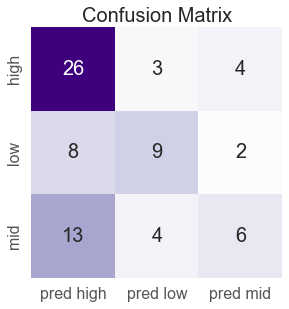

In [936]:
grad_cf.fit(X_train,y_train)
y_pred = grad_cf.predict(X_test)
conmat = np.array(confusion_matrix(y_test, y_pred))
confusion = pd.DataFrame(conmat, index = ["high","low","mid"], columns = ["pred high","pred low","pred mid"])
print confusion
                  
plt.figure(figsize = (4.5,4.5))
heat = sns.heatmap(confusion, annot=True, annot_kws={"size": 20},cmap='Purples',fmt='g', cbar=False)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.title("Confusion Matrix", fontsize=20)

In [1111]:
# check feature importance
feat_impt = pd.DataFrame(zip(x.columns.values,grad_cf.feature_importances_), columns = ["Feature","Importance"])
feat_impt.sort_values("Importance", ascending=False).head(10)

,Feature,Importance
1,Runtime,0.139560
31,Gross_real_i,0.132816
4,tomatoFresh,0.126969
0,Year,0.116051
32,Budget_real_i,0.109544
3,tomatoRotten,0.060768
7,Plot Count,0.058255
9,Oscar,0.049277
2,tomatoMeter,0.028892
29,Rated_R,0.022994


Blog post can be found here: http://pclt.github.io/Movies/